In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import random
import scipy.stats as stats
pd.set_option("display.max_rows", 100000,"display.max_columns", 100)
# !pip install dingsound
import dingsound as d
%matplotlib inline

In [ ]:
!git clone 'https://github.com/sangtrankt98/njv_capacity.git'
# ! ls
# ! rm -rf '/content/njv_capacity'

Cloning into 'njv_capacity'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 66 (delta 24), reused 52 (delta 20), pack-reused 0
Unpacking objects: 100% (66/66), done.


## import data

Notes:
- FM only combine C2C pick up orders
- LM only combine orders deli, ignore RTS orders
- Eliminate hubs had volume/day <= 20, created_month <= Mar 2021

In [ ]:
lm= pd.read_csv('/content/njv_capacity/capacity calculation/lm_index.csv')
rts= pd.read_csv('/content/njv_capacity/capacity calculation/rts_index.csv')
kpi= pd.read_csv('/content/njv_capacity/capacity calculation/kpi_index.csv')
driver= pd.read_csv('/content/njv_capacity/capacity calculation/driver_index.csv')
hub= pd.read_csv('/content/njv_capacity/capacity calculation/hubs.csv')

In [ ]:
# lm['shipper_group'].unique()
# lm['hub_id'].nunique()
# lm.info()
# rts.info()
# hub.info()
driver.info()
# hub['created_month'].sort_values().unique()
# np.unique(fm['hub_name'], return_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75215 entries, 0 to 75214
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cal_date   75215 non-null  object
 1   hub_name   75215 non-null  object
 2   rider_no   75215 non-null  int64 
 3   parcel_no  75215 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [ ]:
kpi
# hub[hub['hub_name']=='HCM - Go Vap B - SOU - DP']

,shipper_group,first_pu_ontime_rate,pu_success_ontime_rate,first_deli_ontime_rate,deli_succcess_ontime_day1_rate,success_rate,check1,check2,check3,check4,check5
0,DS,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
1,EN,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
2,Lazada Master Account (ASC),0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
3,Others,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
4,Self-Signup,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
5,Shopee Vietnam,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
6,Tiki Marketplace,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
7,ES,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
8,XB,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1
9,Affiliate,0.9,0.9,0.9,0.9,0.9,1,1,1,1,1


# combine FM + LM

## agg data

In [ ]:
# +0.05*aggregated['succcess_day3_OTP']
aggregated1 = lm.merge(rts,how='left',on= ['cal_date','shipper_group','hub_id'])
aggregated2 = aggregated1.merge(hub[['hub_id','hub_name','province_code','hub_region','created_month']],how='inner',on=['hub_id'])
aggregated = aggregated2.merge(kpi,how='left',on=['shipper_group'],suffixes=('','_kpi'))
aggregated.fillna(value = 0,inplace=True)
aggregated['cal_date']=pd.to_datetime(aggregated['cal_date'],format='%Y-%m-%d')
aggregated['created_month']=pd.to_datetime(aggregated['created_month'],format='%Y-%m')


## get calculation data

> review data

In [ ]:
# aggregated.info()

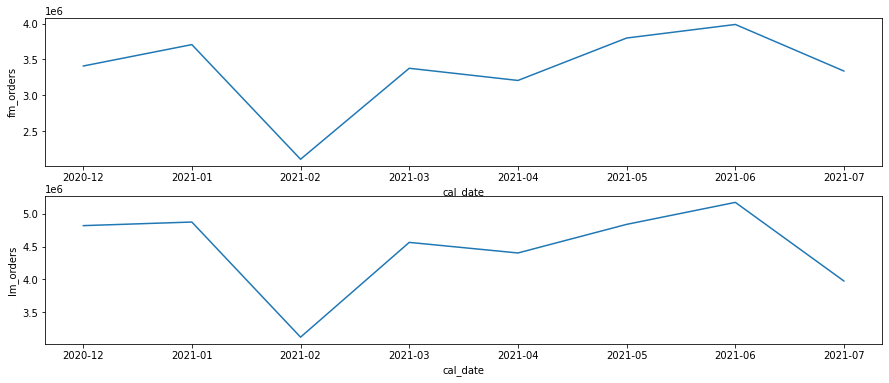

In [ ]:
test=aggregated.groupby(aggregated['cal_date'].dt.strftime("%Y-%m")).agg({'lm_orders':'sum'})
fig,ax = plt.subplots(2,1,figsize=(15, 6))
sns.set_theme(style="darkgrid")
sns.lineplot(x="cal_date", y='lm_orders',data=test,markers=True,dashes=True,ax=ax[1])

In [ ]:
# prepare conditions
filter_date='2021-04-30'
calculation=aggregated[(aggregated['cal_date']<=filter_date)]

## calculate score

### total volume

In [ ]:
calculation['total_volume']= calculation.apply(lambda row: 0 + row.lm_orders, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### percentage volume (by hub&date)



In [ ]:
# Calculation the percentage of each shipper group
percentage=calculation.groupby(['cal_date','hub_name','shipper_group']).agg({'total_volume':'sum'}).groupby(['cal_date','hub_name']).apply(lambda x: x/x.sum()).reset_index()
percentage.sort_values(by=['cal_date','hub_name'],inplace= True)
percentage.fillna(value = 0,inplace=True)
percentage.columns=['cal_date', 'hub_name', 'shipper_group', 'total_volume_percentage']
# percentage[percentage['total_volume'].isnull()]

In [ ]:
calculation=calculation.merge(percentage,how='left',on=['cal_date','shipper_group','hub_name'])

In [ ]:
calculation['check6']=calculation['first_deli_ontime_rate'].ne(0).astype(int)
calculation['check7']=calculation['deli_succcess_ontime_day1_rate'].ne(0).astype(int)
calculation['check8']=calculation['first_pu_ontime_rate'].ne(0).astype(int)
calculation['check9']=calculation['pu_success_ontime_rate'].ne(0).astype(int)
calculation['check10']=calculation['success_rate'].ne(0).astype(int)

### service level

In [ ]:
# Calculate service level score
calculation['actual_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate*x.check1 + x.deli_succcess_ontime_day1_rate*x.check2 + x.success_rate*x.check5)*x.total_volume_percentage , axis=1)
calculation['kpi_score']=calculation.apply(lambda x: (x.first_deli_ontime_rate_kpi*x.check6 + x.deli_succcess_ontime_day1_rate_kpi*x.check7 + x.success_rate_kpi*x.check10)*x.total_volume_percentage , axis=1)

In [ ]:
# calculation.head(5)

In [ ]:
pre_final=calculation[['cal_date','shipper_group','hub_name','total_volume','actual_score','kpi_score']]

## stats analysis

> filter time + avg volumn/day < 20

In [ ]:
pre_final = pre_final[pre_final['total_volume'].isnull()==False]
filter = pre_final.groupby('hub_name').agg({'total_volume':'mean'}).reset_index()
hub_low_performance=filter[filter['total_volume']<=20]['hub_name'].to_list()
pre_final=pre_final[~pre_final['hub_name'].isin(hub_low_performance)]

In [ ]:
filter[filter['total_volume']<=10].sort_values(by='total_volume').to_csv('/content/drive/MyDrive/Desktop/low_workload.csv')

> review data

In [ ]:
final=pre_final.groupby(['cal_date','hub_name']).agg({'total_volume':'sum','actual_score':'sum','kpi_score':'sum'}).reset_index()

In [ ]:
final=final[final['actual_score']>=final['kpi_score']]

In [ ]:
calculation[calculation['hub_name']=='HCM - Go Vap B - SOU - DP'].groupby(calculation['cal_date'].dt.strftime("%Y-%m")).agg({'lm_orders':'sum'})

,lm_orders,fm_orders
cal_date,,
2020-12,36.0,85.0
2021-01,0.0,60.0
2021-02,0.0,56.0
2021-03,0.0,221.0
2021-04,70.0,385.0


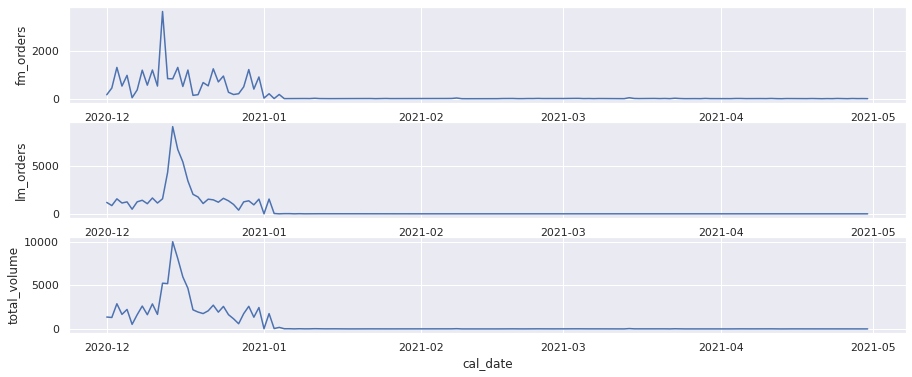

In [ ]:
test=calculation[calculation['hub_name']=='HN - Hai Ba Trung 2 - NOR - DP'].groupby(calculation['cal_date']).agg({'total_volume':'sum'})
# test=calculation.groupby(calculation['cal_date']).agg({'lm_orders':'sum','fm_orders':'sum','total_volume':'sum'})
fig,ax = plt.subplots(3,1,figsize=(15, 6))
sns.set_theme(style="darkgrid")
sns.lineplot(x="cal_date", y='lm_orders',data=test,markers=True,dashes=True,ax=ax[1])
sns.lineplot(x="cal_date", y='total_volume',data=test,markers=True,dashes=True,ax=ax[2])

### z-score & remove outlier

In [ ]:
final['z_score_total_volume']=final.groupby(['hub_name']).total_volume.transform(lambda x : stats.zscore(x,ddof=1))
# final['t_score_total_volume']=final.groupby(['hub_name']).total_volume.transform(lambda x : stats.t.interval(0.9,final['total_volume'], loc=np.mean(x), scale=stats.sem(x)))
final['mean_total_volume']=final.groupby(['hub_name']).total_volume.transform(lambda x : x.mean())
final['std_total_volume']=final.groupby(['hub_name']).total_volume.transform(lambda x : x.std(ddof=1))

In [ ]:
# final.to_csv('/content/drive/MyDrive/Desktop/check.csv')

Text(0.5, 1.0, 'hub_name')

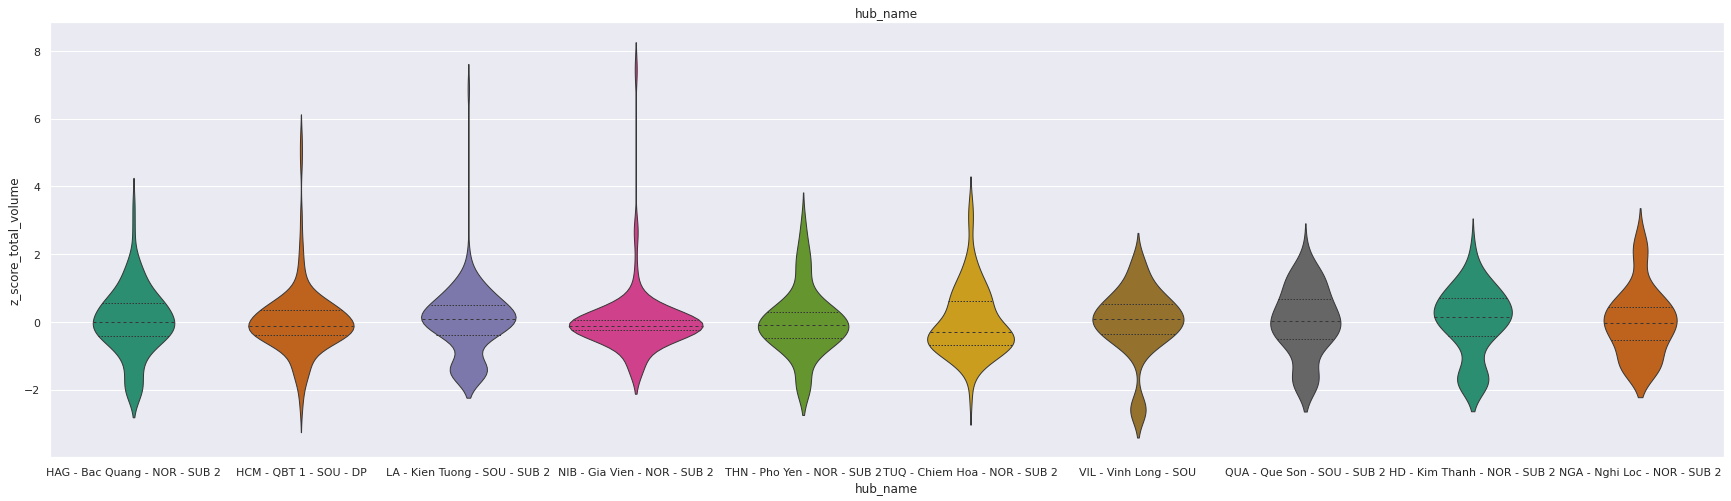

In [ ]:
hub_rand = random.sample(final['hub_name'].unique().tolist(),10)
fig, ax1 = plt.subplots(1,1,figsize=(30,8),squeeze =False)
sns.set_theme(style="whitegrid")
sns.violinplot(data=final[final['hub_name'].isin(hub_rand)],x='hub_name',y='z_score_total_volume',linewidth=1,inner="quartile",ax=ax1[0,0],palette='Dark2')
# sns.boxplot(data=df3,x='target',y='hub_region',ax=ax1[0,2],palette='Dark2')
ax1[0,0].set_title('hub_name')

In [ ]:
final['q1_z']=final.groupby(['hub_name']).z_score_total_volume.transform(lambda x : x.quantile(.25))
final['q3_z']=final.groupby(['hub_name']).z_score_total_volume.transform(lambda x : x.quantile(.75))
final['lower_z']=final.apply(lambda x: 2.5*x.q1_z-1.5*x.q3_z, axis=1)
final['upper_z']=final.apply(lambda x: 2.5*x.q3_z-1.5*x.q1_z, axis=1)

In [ ]:
final = final[(final['z_score_total_volume']>=final['lower_z'])&(final['z_score_total_volume']<=final['upper_z'])]

Text(0.5, 1.0, 'hub_name')

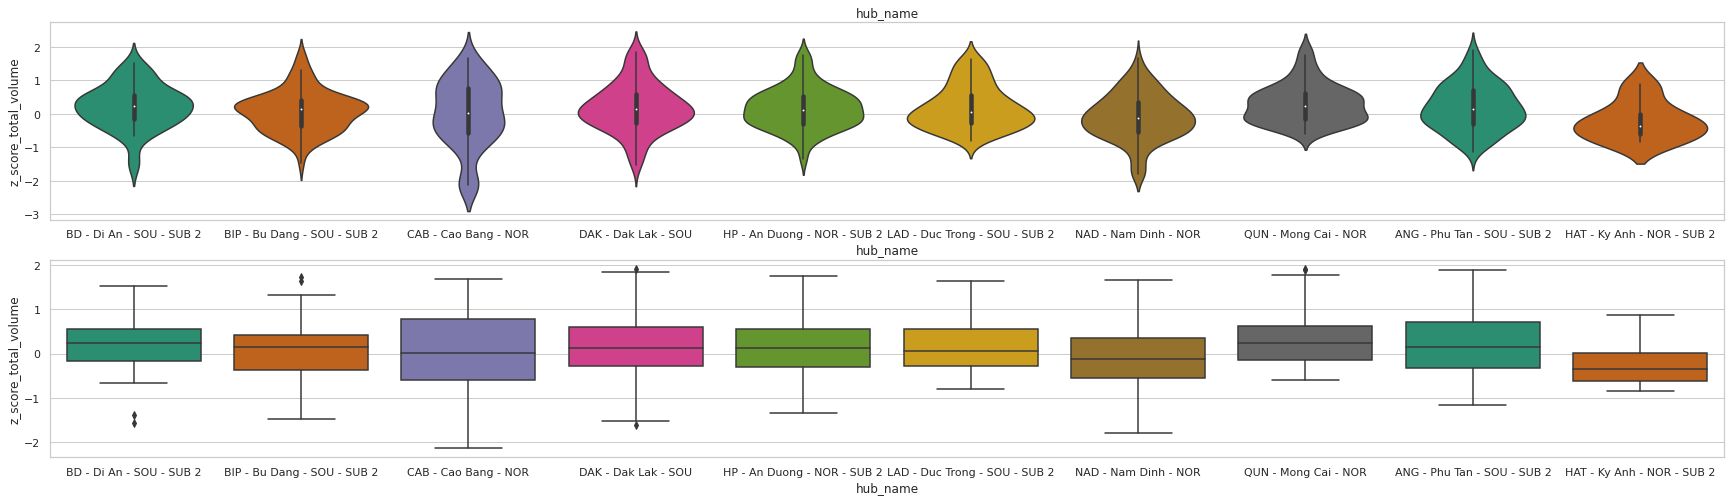

In [ ]:
hub_rand = random.sample(final['hub_name'].unique().tolist(),10)
fig, ax1 = plt.subplots(2,1,figsize=(30,8),squeeze =False)
sns.set_theme(style="whitegrid")
sns.violinplot(data=final[final['hub_name'].isin(hub_rand)],x='hub_name',y='z_score_total_volume',ax=ax1[0,0],palette='Dark2')
sns.boxplot(data=final[final['hub_name'].isin(hub_rand)],x='hub_name',y='z_score_total_volume',ax=ax1[1,0],palette='Dark2')
# sns.boxplot(data=df3,x='target',y='hub_region',ax=ax1[0,2],palette='Dark2')
ax1[0,0].set_title('hub_name')

> which type of distribution

Text(0, 0.5, 'Density')

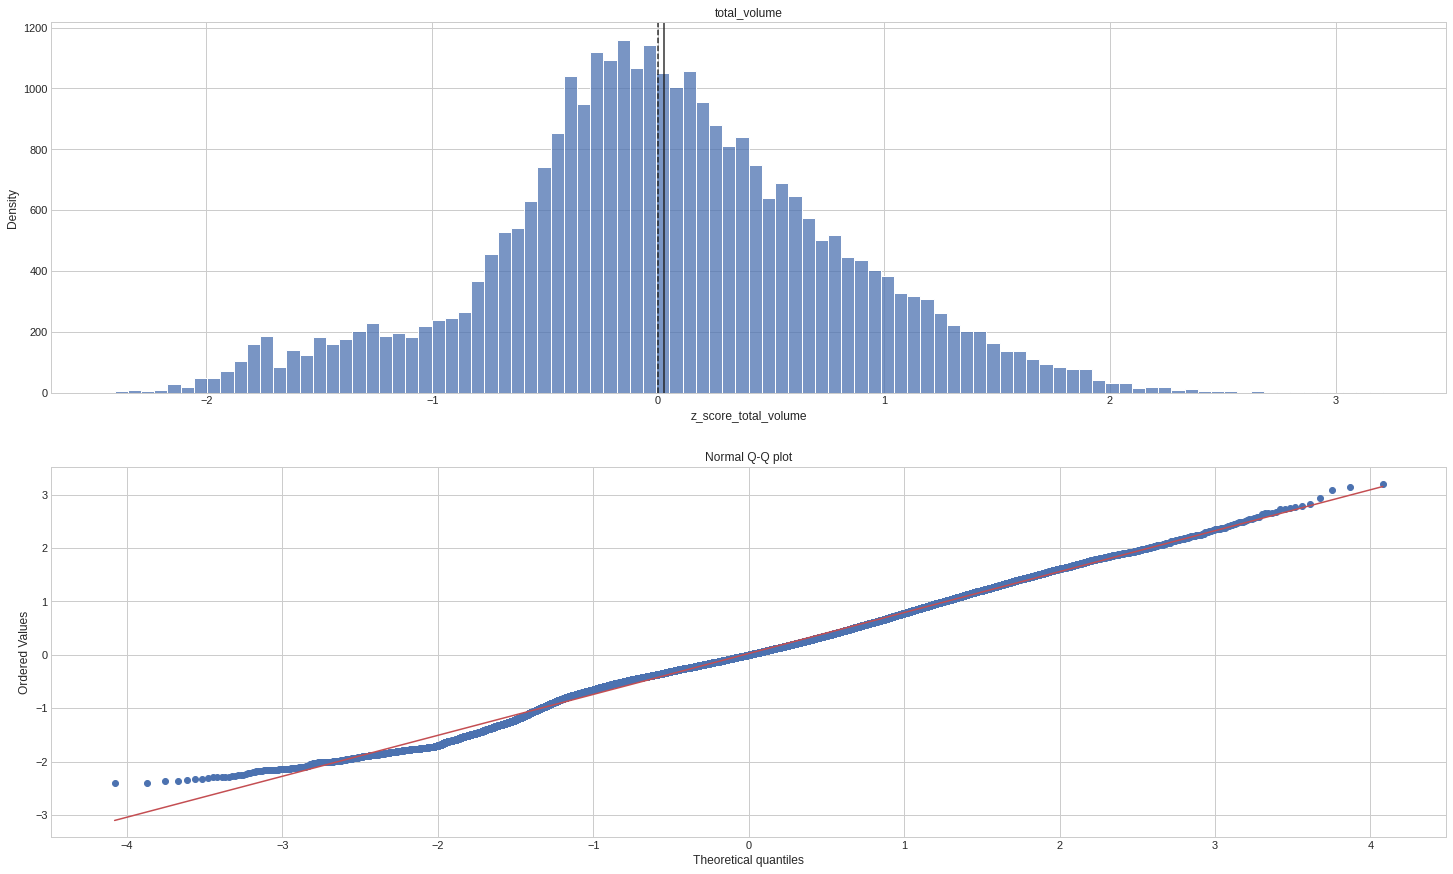

In [ ]:
# plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(2, 1, figsize=(25, 15))
sns.histplot(data=final,x=final['z_score_total_volume'],ax=ax[0])
# stats.probplot(final['z_score_total_volume'], dist=stats.loggamma, plot=ax[2])
ax[0].axvline(np.mean(final['z_score_total_volume']), color='k', label='Mean', linestyle='-', alpha=0.9)
ax[0].axvline(np.median(final['z_score_total_volume']), color='k', label='Median', linestyle='--', alpha=0.9)

stats.probplot(final['z_score_total_volume'], dist=stats.norm, plot=ax[1])

# Plot formatting
ax[1].set_title('Normal Q-Q plot')
ax[0].set_title('total_volume')
ax[0].set_xlabel('z_score_total_volume')
ax[0].set_ylabel('Density')

### confidence interval

In [ ]:
hub_name = final['hub_name'].unique()
result= pd.DataFrame() 
for hub in hub_name:
  data=stats.bayes_mvs(final[final['hub_name']==hub]['total_volume'],alpha= 0.9)
  dict =  {
  'hub_name':hub,
  'mean': [data[0][0]],
  'lower': [data[0][1][0]],
  'upper': [data[0][1][1]]
  }
  append = pd.DataFrame.from_dict(dict)
  result= result.append(append)

In [ ]:
# result = final.merge(result,how='left',on='hub_name').reset_index()

In [ ]:
result=result.reset_index()

In [ ]:
map_driver= driver.merge(result,how='inner',on = ['hub_name'])

In [ ]:
map_driver.head(4)

,cal_date,hub_name,rider_no,parcel_no,index,mean,lower,upper
0,2020-12-01,HN - Hai Ba Trung 2 - NOR - DP,25,1370,0,7.745455,6.646149,8.84476
1,2020-12-26,HN - Hai Ba Trung 2 - NOR - DP,22,1135,0,7.745455,6.646149,8.84476
2,2020-12-04,HN - Hai Ba Trung 2 - NOR - DP,22,1273,0,7.745455,6.646149,8.84476
3,2021-01-02,HN - Hai Ba Trung 2 - NOR - DP,27,1724,0,7.745455,6.646149,8.84476


In [ ]:
final_result = map_driver[(map_driver['parcel_no']<=map_driver['upper'])&(map_driver['parcel_no']>=map_driver['lower'])].groupby('hub_name').agg({'mean':'mean','lower':'mean','upper':'mean','rider_no':'mean'})

In [ ]:
final_result.round().reset_index()

,hub_name,mean,lower,upper,rider_no
0,ANG - An Giang - SOU,653.0,620.0,685.0,11.0
1,ANG - An Phu - SOU - SUB 2,212.0,192.0,232.0,4.0
2,ANG - Chau Doc - SOU - SUB 2,694.0,648.0,740.0,11.0
3,ANG - Phu Tan - SOU - SUB 2,738.0,711.0,764.0,13.0
4,ANG - Tri Ton - SOU - SUB 2,179.0,158.0,199.0,3.0
5,BAG - Bac Giang - NOR,1194.0,1152.0,1237.0,16.0
6,BAG - Hiep Hoa - NOR - SUB 2,613.0,584.0,643.0,10.0
7,BAG - Luc Nam - NOR - SUB 2,396.0,354.0,438.0,9.0
8,BAG - Luc Ngan - NOR - SUB 2,221.0,212.0,230.0,5.0
9,BAK - Bac Kan - NOR,242.0,221.0,263.0,3.0


In [ ]:
d.ding2()